In [4]:
# import packages

import matplotlib.pyplot as plt
import numpy as np
from lacbox.io import load_pwr, load_oper
from pathlib import Path
from our_values import *
import pandas as pd
from lacbox.io import load_ctrl_txt
from scipy.optimize import curve_fit
from lacbox.io import ReadHAWC2
from lacbox.test import test_data_path

plt.rcParams.update({'font.family': 'serif', 'font.size':16})
from matplotlib.ticker import FormatStrFormatter



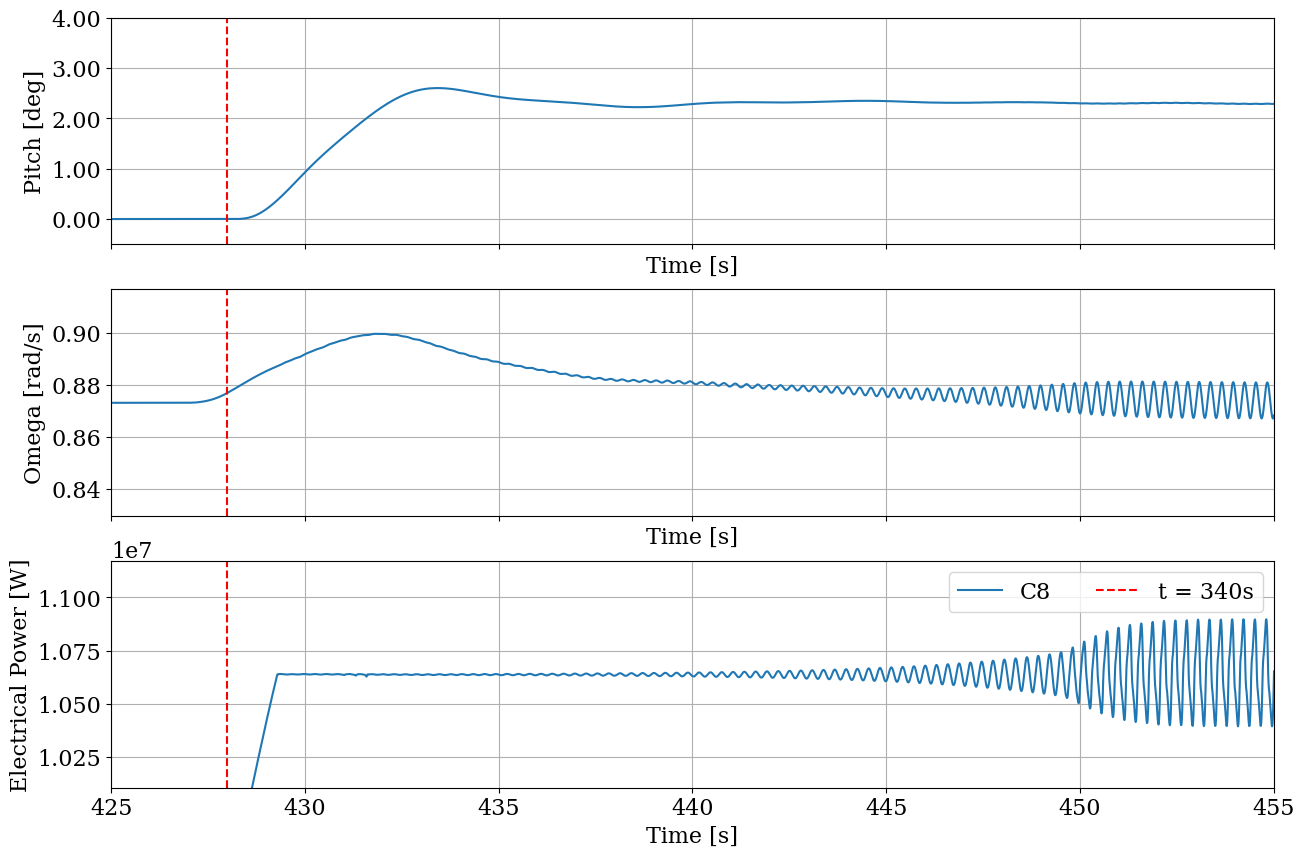

In [6]:
# assignemnt 3, best controller
# it's a nice plot come on

xmin = 425
xmax = 455
fig, (ax_pitch, ax_omega, ax_power) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

k=8
# Filename for each iteration
fname = f'our_design/res/Group1_redesign_hawc2s_step_C{k}.hdf5'
h2res = ReadHAWC2(fname)

# Retrieve channel information
names, units, desc = h2res.chaninfo

# Extract indices for time, WSP, Omega, pitch, and power
idx_Time = np.where(['Time [s]' in name for name in names])[0]
idx_Omega = np.where(['Omega' in name for name in names])[0]
idx_pitch = np.where(['bea2 angle' in name for name in names])[0]
idx_power = np.where(['DLL inp   2:   2' in name for name in names])[0]

# Plot Pitch
ax_pitch.plot(h2res.t, h2res.data[:, idx_pitch[0]], label=f'Pitch (C{k})')

# Plot Omega
ax_omega.plot(h2res.t, h2res.data[:, idx_Omega], label=f'Omega (C{k})')

# Plot Power
ax_power.plot(h2res.t, h2res.data[:, idx_power], label=f'C{k}')



ax_pitch.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_omega.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_power.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')

# Set labels and titles for Pitch plot
ax_pitch.set_xlabel('Time [s]')
ax_pitch.set_ylabel('Pitch [deg]')
ax_pitch.set(xlim=[xmin, xmax])
ax_pitch.set(ylim=[-0.5, 4])
ax_pitch.yaxis.set_major_formatter(FormatStrFormatter('%3.2f'))  # Set y-ticks to 1 decimal
ax_pitch.grid()
#ax_pitch.legend(ncol=2)

# Set labels and titles for Omega plot
ax_omega.set_xlabel('Time [s]')
ax_omega.set_ylabel('Omega [rad/s]')
ax_omega.set(xlim=[xmin, xmax])
ax_omega.set(ylim=[OMEGA_MAX*np.pi/30*0.95, OMEGA_MAX*np.pi/30*1.05])
ax_omega.grid()
#ax_omega.legend(ncol=2)

# Set labels and titles for Power plot
ax_power.set_xlabel('Time [s]')
ax_power.set_ylabel('Electrical Power [W]')
ax_power.set(xlim=[xmin, xmax])
ax_power.set(ylim=[POWER_MAX*0.95, POWER_MAX*1.05])
ax_power.grid()
ax_power.legend(ncol=2)

# Save each figure to a file
#fig_omega.savefig('omega_plot_17.pdf')  # Save Omega plot
#fig_power.savefig('power_plot_17.pdf')  # Save Power plot
#fig_wsp.savefig('wsp_plot_17.pdf')      # Save WSP plot
#fig_pitch.savefig('pitch_plot_17.png')  # Save Pitch plot

# Show all plots
fig.savefig('plots/3_3_14.pdf', format='pdf',bbox_inches='tight')
plt.show()
